# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

In its current form, we first make a selection of conflicts to be used for training and testing the model. Selection criteria are amongst others minimum number of fatalities and climate zones. Subsequently, annual statistics (now: mean) of a range of environmental variables are determined per geographic unit (now: water provinces) and stored along with a 0/1 conflict value. This dataset is then scaled, split, and applied in a machine learning model (now: support vector classification).

All model settings need to be defined in the run_settings.cfg file.

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, preprocessing, model_selection, metrics
from shutil import copyfile
import os, sys

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.2b2
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.optionxform = lambda option: option
config.read(settings_file);

Create the output folder as specified in the settings, in case it does not exist yet.

In [6]:
out_dir = config.get('general','output_dir')
if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir))

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT


Make a copy of the settings file in the output file to always get an idea on what settings the output is based.

In [7]:
copyfile(settings_file, os.path.join(out_dir, 'copy_of_run_setting.cfg'));

# Applying functions

First, get the conflict data base and convert it into a georeferenced dataframe. This is needed for all following steps where this data is combined with other data sources.

In [8]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



Second, get the subset of conflicts based on user-defined conditions in the settings file.

In [9]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2015

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

Add functions to be tested here.

# Analysis per year

This is the core of the code. Here, we go through all model years as specified in the settings-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit or not;
2. Loop through various files with environmental variables and get mean variable value per geographical unit.

This is all stored in a dictionary for easy processing. We first need to initialize this dictionary containing a pandas Series per provided environmental variable. Then, add a pandas Series for the conflict data.

In [10]:
XY = {}
for key in config.items('env_vars'):
    XY[str(key[0])] = pd.Series(dtype=float)
XY['conflict'] = pd.Series(dtype=int)
XY

{'GDP_per_capita_PPP': Series([], dtype: float64),
 'total_evaporation': Series([], dtype: float64),
 'precipitation': Series([], dtype: float64),
 'surface_water_storage': Series([], dtype: float64),
 'upper_soil_storage': Series([], dtype: float64),
 'groundwater_recharge': Series([], dtype: float64),
 'temperature': Series([], dtype: float64),
 'conflict': Series([], dtype: int32)}

Now let's go through all years and all files and data and assign the values to the corresponding Series in the dictionary.

In [26]:
print('simulation period from', str(config.getint('settings', 'y_start')), 'to', str(config.getint('settings', 'y_end')))
print('')

# go through all simulation years as specified in config-file
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):
    
    print('entering year {}'.format(sim_year) + os.linesep)
    
    # go through all keys in dictionary
    for key, value in XY.items():
        
        if key == 'conflict':
            data_series = value
            data_list = conflict_model.get_boolean_conflict.conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year)
            data_series = data_series.append(pd.Series(data_list), ignore_index=True)
            XY[key] = data_series
            
        else:
            nc_fo = os.path.join(config.get('general', 'input_dir'), 
                                 config.get('env_vars', key))
            
            print('calculating mean {0} per aggregation unit from file {1} for year {2}'.format(key, nc_fo, sim_year))

            nc_ds = xr.open_dataset(nc_fo)
            
            print(np.dtype(nc_ds.time))
            
            if (np.dtype(nc_ds.time) == np.float32) or (np.dtype(nc_ds.time) == np.float64):
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_float_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
            if np.dtype(nc_ds.time) == 'datetime64[ns]':
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_continous_datetime_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
print('...simulation DONE')

simulation period from 2000 to 2015

entering year 2000

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2000
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2001

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2001
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2001


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2002

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2002
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2002


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2003

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2003
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2003


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2004

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2004
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2004


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2005

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2005
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2005


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2006

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2006
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2006


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2007

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2007
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2007


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2008

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2008
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2008


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2009

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2009
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2010

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2010
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2010


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2011

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2011
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2011


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2012

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2012
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2012


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2013

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2013
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2013


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

entering year 2014

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2014
float32
boring
calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/precip/precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean surface_water_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/surfaceWaterStorage_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean upper_soil_storage per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/storUppTotal_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean groundwater_recharge per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/gwRecharge_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014
datetime64[ns]
GDPPPP
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2014


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

determining whether a conflict took place or not
...DONE

...simulation DONE


# Machine Learning

## Data preparation

First, create a pandas dataframe from the dictionary and kick out rows with missing values (they do not work with ML)

In [28]:
XY = pd.DataFrame.from_dict(XY)
print('number of data points including missing values:', len(XY))
XY = XY.dropna()
print('number of data points excluding missing values:', len(XY))

number of data points including missing values: 57900
number of data points excluding missing values: 5760


Then, convert them to numpy arrays, separately for the variables (X) and the target conflict (Y).

In [29]:
X = XY.to_numpy()[:, :-1] # since conflict is the last column, we know that all previous columns must be variable values
X

array([[ 2.36193426e+03,  4.23162297e-02,  5.90158959e-02, ...,
         6.71801438e-02,  2.10162193e-03,  1.69482798e+01],
       [ 3.10405169e+03,  4.05202232e-02,  4.38823540e-02, ...,
         2.82066820e-02, -3.58544960e-05,  2.62989597e+01],
       [ 1.19202521e+03,  3.92765536e-02,  3.85574701e-02, ...,
         3.64529623e-02,  1.03662429e-05,  2.41465799e+01],
       ...,
       [ 1.70019058e+03,  4.56631968e-02,  7.90373737e-02, ...,
         4.87843844e-02,  1.87078884e-03,  1.99556426e+01],
       [ 1.71027506e+03,  4.38179032e-02,  5.47764229e-02, ...,
         3.49697695e-02,  5.63143250e-04,  2.20619215e+01],
       [ 1.71202357e+03,  5.35152570e-02,  5.75030690e-02, ...,
         3.40937642e-02,  1.34886359e-03,  2.21496095e+01]])

In [30]:
Y = XY.conflict.astype(int).to_numpy()
Y

array([0, 0, 0, ..., 0, 0, 0])

### Target evaluation

Let's have a closer look at what we actualy work with. This is essential to select and tune the right ML model, for instance.

In [31]:
print('the total number of data points for our target is', len(Y))

the total number of data points for our target is 5760


In [32]:
print('from this, {0} points are equal to 1, i.e. represent conflict occurence. This is a fraction of {1} percent.'.format(len(np.where(Y != 0)[0]), round(100*len(np.where(Y != 0)[0])/len(Y), 2)))

from this, 310 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 5.38 percent.


## Data preprocessing

Before we can train and predict with the model, we need to scale the variable data and create trainings and test data for both variables and target.

There are different scaling algorithms available. For our application, the MinMaxScaler and StandardScaler are the most obvious choices, the RobustScaler is follow-up. Depending on how incoming data looks like and is distributed, the scaling decision may need to be updated.

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

In [33]:
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.RobustScaler()
scaler = preprocessing.QuantileTransformer()

The scaler is then used to fit the data and transform it according to scaler-specific method. I don't scale Y since it is either 0 or 1 already.

In [34]:
X_scaled = scaler.fit_transform(X)

The scaled variable data X_scaled is, together with the target data Y, split into trainings and test data. The fraction of the total data that is used for training is user-defined.

In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled,
                                                                    Y,
                                                                    test_size=1-config.getfloat('machine_learning', 'train_fraction'))

The scatterplot of the first two variables in X_train looks like this. Also the sample size n_train is provided used to train the data alongside with the total variable sample size n_tot.

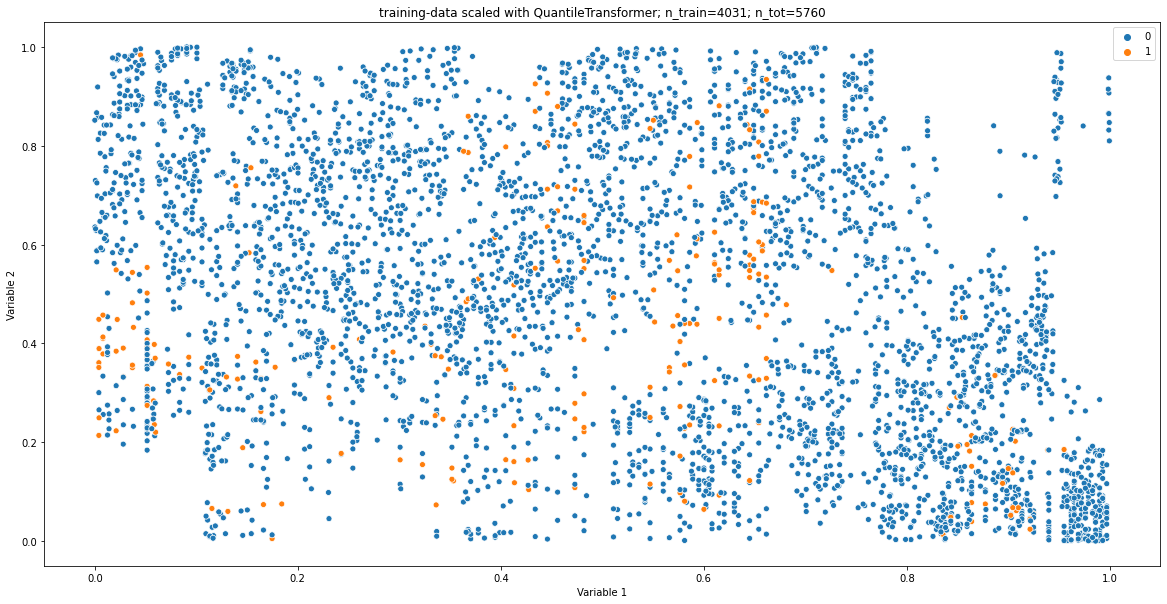

In [36]:
plt.figure(figsize=(20,10))
sbs.scatterplot(x=X_train[:,0],
                y=X_train[:,1],  
                hue=y_train)

plt.title('training-data scaled with {0}; n_train={1}; n_tot={2}'.format(str(scaler).rsplit('(')[0], len(X_train), len(X_scaled)))
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.savefig(os.path.join(out_dir, 'scatter_plot_scaled_traindata_{}.png'.format(str(scaler).rsplit('(')[0])), dpi=300)
plt.show()

A brief look at the statistics of the data of our scaled and standardized variables.

In [37]:
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(array([0.50001379, 0.50000215, 0.49999846, 0.49997511, 0.50000012,
        0.49999594, 0.50000184]),
 array([0.28874004, 0.28872487, 0.28872706, 0.28875994, 0.28872483,
        0.28872383, 0.28872317]))

## Model

### Train and predict

Create Support Vector Classification (SVC) model with balanced weight since data is unbalanced (e.g. many negative and few positive).

Note that there are many many settings in the svm.SVC class to be altered. At the moment, we stick to defaults besides the class_weight.

In [38]:
clf = svm.SVC(class_weight='balanced')

Fit the model with the scaled training data and the boolean conflict data

In [39]:
clf.fit(X_train, y_train);

Predict with the scaled prediction data. We see an array with lots of 0 and 1 is produced, similar as the target data of the model, y_test.

In [40]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 1])

No clue right now what this does... look it up!

In [41]:
y_score = clf.decision_function(X_test)
y_score

array([-0.26710357, -0.66121614,  0.97610746, ..., -1.25507728,
       -2.24726452,  0.52650106])

### Evaluation

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [42]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.7241179872758821
Precision: 0.13644859813084112
Recall: 0.8295454545454546


**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [43]:
average_precision = metrics.average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.24


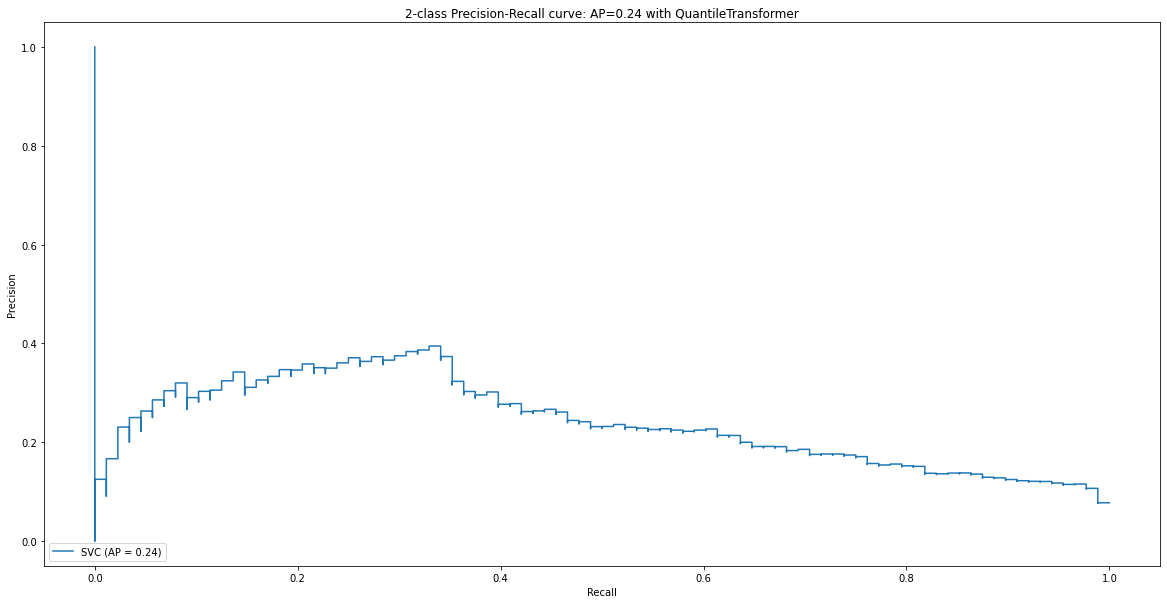

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
disp.ax_.set_title('2-class Precision-Recall curve: AP={} with {}'.format(round(average_precision,2), str(scaler).rsplit('(')[0]))
plt.savefig(os.path.join(out_dir, 'precision_recall_curve_{}.png'.format(str(scaler).rsplit('(')[0])), dpi=300)

Results are pretty crappy, but that is okay give we use not very sensible input data at the moment...

# Documentation

Let's safe some settings used in this run to csv-files so results can be assessed in light of these settings.

First, the parameters of our SVM model.

In [45]:
SVC_params = clf.get_params()

out_fo = os.path.join(out_dir, 'SVC_params.csv')
w = csv.writer(open(out_fo, "w"))
for key, val in SVC_params.items():
    w.writerow([key, val])

Second, the parameters of the scaling method we used.

In [46]:
scaler_params = scaler.get_params()

out_fo = os.path.join(out_dir, '{}_params.csv'.format(str(scaler).rsplit('(')[0]))
w = csv.writer(open(out_fo, "w"))
for key, val in scaler_params.items():
    w.writerow([key, val])

Third, the resulting values of our objective functions.

In [47]:
evaluation = {'Accuracy': round(metrics.accuracy_score(y_test, y_pred), 2),
              'Precision': round(metrics.precision_score(y_test, y_pred), 2),
              'Recall': round(metrics.recall_score(y_test, y_pred), 2),
              'Average precision-recall score': round(average_precision, 2)}

out_fo = os.path.join(out_dir, 'evaluation.csv')
w = csv.writer(open(out_fo, "w"))
for key, val in evaluation.items():
    w.writerow([key, val])